# CAB420 - Troubleshooting Help: Regression Edition
Dr Simon Denman (s.denman@qut.edu.au)
Dr Ethan Goan (e.goan@qut.edu.au)

## Overview

Anyone who has done any amount of software development will know that it's not a matter of if things will go wrong, it's only a matter of when. This notebook will contain a walkthrough of some common errors we have seen students make over the past few years, some hints for diagnosing whats going on and why, and solutions to these errors. It is hoped that this notebook will serve as a bit of a first port of call for whatever issues you might encounter throughout CAB420. I will put a bit of narrative around the topics here so you can maybe get a bit more of an understanding, but this isn't something here that we expect you all to read from top to bottom. This is more along the lines of you should be able to `Ctrl-f` what you need, and then maybe just read the section for things giving you grief; or perhaps find the right section based on the other information on Canvas that's leading you to this.

We will use the term "error" here in a more broad sense, where "error" means things simply not working as you intended. This could include python spitting some red wall of text at you for a programming error, or a model failing to yield any meaningful output when put to the test. 

### Regression Edition

This notebook is particularly focussed on regression errors. There are lots of possible errors in CAB420 - putting them all in one notebook just seemed a bit much.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime, date
import itertools

/tmp/ipykernel_71/2203397129.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Some data

We'll use the data from Prac's 1 and 2. Loading and splitting code is taken directly from there. Note that I'm creating two version of the data:
* One with the NaNs remove
* One with the NaNs left in

In [2]:
# load data
combined = pd.read_csv('../data/BrisbaneData/combined.csv')
combined['Date']= pd.to_datetime(combined['Date'])
# filtered version of data
combined_filtered = combined.dropna(axis=1, thresh=combined.shape[0] - 300).dropna(axis=0)
# splits, with NaNs still in
train = combined[combined.Date < datetime(year=2017, month=1, day=1)]
val = combined[((combined.Date >= datetime(year=2017, month=1, day=1)) & 
                (combined.Date < datetime(year=2018, month=1, day=1)))]
test = combined[((combined.Date >= datetime(year=2018, month=1, day=1)) & 
                 (combined.Date < datetime(year=2019, month=1, day=1)))]
# splits, with NaNs removed
train_filtered = combined_filtered[combined_filtered.Date < datetime(year=2017, month=1, day=1)]
val_filtered = combined_filtered[((combined_filtered.Date >= datetime(year=2017, month=1, day=1)) & 
                                  (combined_filtered.Date < datetime(year=2018, month=1, day=1)))]
test_filtered = combined_filtered[((combined_filtered.Date >= datetime(year=2018, month=1, day=1)) & 
                                   (combined_filtered.Date < datetime(year=2019, month=1, day=1)))]

# pull out variables to use
# select from filtered version of the data as this contains a subset of the columns
X_bom = ['Rainfall amount (millimetres)',
         'Daily global solar exposure (MJ/m*m)',
         'Maximum temperature (Degree C)']
X_bcc = [x for x in train_filtered.columns.values if 'Cyclists Inbound' in x]
X_bcc.remove('Bicentennial Bikeway Cyclists Inbound')
X_variables = X_bom + X_bcc
Y_variable = 'Bicentennial Bikeway Cyclists Inbound'

# pull out x and y for non-filtered data
Y_train = np.array(train[Y_variable], dtype=np.float64)
X_train = np.array(train[X_variables], dtype=np.float64)
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)

# pull out x and y for filtered data
Y_train_filtered = np.array(train_filtered[Y_variable], dtype=np.float64)
X_train_filtered = np.array(train_filtered[X_variables], dtype=np.float64)
Y_val_filtered = np.array(val_filtered[Y_variable], dtype=np.float64)
X_val_filtered = np.array(val_filtered[X_variables], dtype=np.float64)
Y_test_filtered = np.array(test_filtered[Y_variable], dtype=np.float64)
X_test_filtered = np.array(test_filtered[X_variables], dtype=np.float64)

# NOTE - At this point I should add a constant term to the data. The data has not been standardised, so this
# woudl be the correct thing to do. This, however, is also a common error - and it's an error that we're 
# going to demonstrate later, so I'm not doing it. The code I would use to do this is commented out below.
#X_train = sm.add_constant(X_train)
#X_val = sm.add_constant(X_val)
#X_test = sm.add_constant(X_test)
#X_train_filtered = sm.add_constant(X_train_filtered)
#X_val_filtered = sm.add_constant(X_val_filtered)
#X_test_filtered = sm.add_constant(X_test_filtered)

## NaNs in the Training Data

We'll start off with an easy one - not cleaning your training data and leaving some NaNs in it.

In [3]:
# create the linear model
# using non-cleaned data here
model = sm.OLS(Y_train, X_train)
# fit the model
model_fitted = model.fit()

MissingDataError: exog contains inf or nans

The error I get here is pretty helpful: `MissingDataError: exog contains inf or nans`.

Training data need to be cleaned up before use. Note that different packages may be more forgiving and may automatically drop rows with missing values. `statsmodels` however is not so forgiving.

## NaNs in the Validation/Testing Sets

Let's clean the training data now, but forget to clean the validation or testing data. Here we'll just the validation data, but you'd see the same issue on the test data.

In [4]:
# create the linear model - this time use filtered data
model = sm.OLS(Y_train_filtered, X_train_filtered)
# fit the model
model_fitted = model.fit()

# get some predictions - but we forgot to use the filtered data
preds = model_fitted.predict(X_val)

# get an RMSE
val_rmse = np.sqrt(np.mean(np.power(preds - Y_val, 2.0)))
# print some stuff
print(val_rmse)
print(preds[0:100])

nan
[ 335.17935821  800.1954437  1078.04682308 1681.82959113 1745.99185266
 1517.78506971 1076.12770759 2007.31789873 1976.27284274 2258.75039681
 2070.42358653 1735.50841484 1388.61899669  754.06750184  731.02143923
 1668.23414377 2409.675198   2360.59196599 1858.38407963 1663.05710011
  805.03142164 1255.7688043  1947.21655371 2485.23302768 2081.11157195
 1069.09298221 1453.93924387  918.49312727 1222.85513828           nan
           nan 1607.74931914 1544.73251721 1391.4050976   978.09909074
 1221.03010175 1569.7311024            nan 1826.99046641 1370.59502466
 1345.41407359  848.1061695   646.95824173 1484.2886739  2160.02057907
 2250.76735197 2081.03368526 1608.32389084 1335.78863848 1241.22730633
 1676.61938809 2356.61390088 2181.80215864 2145.73105667 1734.15944302
 1197.55386305 1474.08789512 2133.18194259 2659.71814548 2417.59522743
 2433.9942167  1649.99399374 1403.92168993 1231.77930215 1637.59738754
 1555.33583189 1821.79882628 1453.10946674 1475.82409627 1290.06186757
 1

Here we don't get any angry red text. Things run, but we get some sub-optimal results. In particular we see:
* `val_rmse` is nan
* looking at some of our predictions, we see nans for some samples

Any sample which contains a NaN in the input is giving us a NaN in the output. When we then take the average of these values, having any single NaN leads to our average (and thus RMSE) also being NaN. 

NaNs in your validaiton or test data won't cause red text, but will cause other issues down stream. Check values like your RMSE to make sure you don't have this issue.

## X and y in the Wrong Order

An easy mistake to make.

In [5]:
# create the linear model
model = sm.OLS(X_train_filtered, Y_train_filtered)
model_fitted = model.fit()

This surprised me. The above cell was meant to fail.

Let's see what does fail.

In [6]:
preds = model_fitted.predict(X_val_filtered)

ValueError: shapes (276,7) and (1,7) not aligned: 7 (dim 1) != 1 (dim 0)

Passing in the X data here causes an error. This is becuase our model has been trained with one predictor, so when it get's 7 it's unhappy.

In [7]:
preds = model_fitted.predict(Y_val_filtered)
print(preds.shape)

(276, 7)


To understand what's going on here, we'll pass in the y data and make some predictions. We can see that our output is now `(276, 7)`, we've made 7 predictions for each sample.

What's actually happened here is that statsmodels has learnt 7 linear regressors, one for each output. This is a really bad way to use statsmodels, and I do not recommend doing this.

In [8]:
model_fitted.summary()

ValueError: shapes (888,7) and (888,7) not aligned: 7 (dim 1) != 888 (dim 0)

If we try and print a summary of the model, we also get an error. I think this is simply because statsmodels does not know how to summarise the 7 models into some nice, clean output.

## Missing Constant Term

This is an easy mistake to make, and not necessarily an easy one to pick up.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.827
Model:                            OLS   Adj. R-squared (uncentered):              0.825
Method:                 Least Squares   F-statistic:                              599.9
Date:                Tue, 06 Feb 2024   Prob (F-statistic):                        0.00
Time:                        05:50:50   Log-Likelihood:                         -6913.0
No. Observations:                 888   AIC:                                  1.384e+04
Df Residuals:                     881   BIC:                                  1.387e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0.5, 1.0, 'Histogram of Residuals, mu = 0.00')

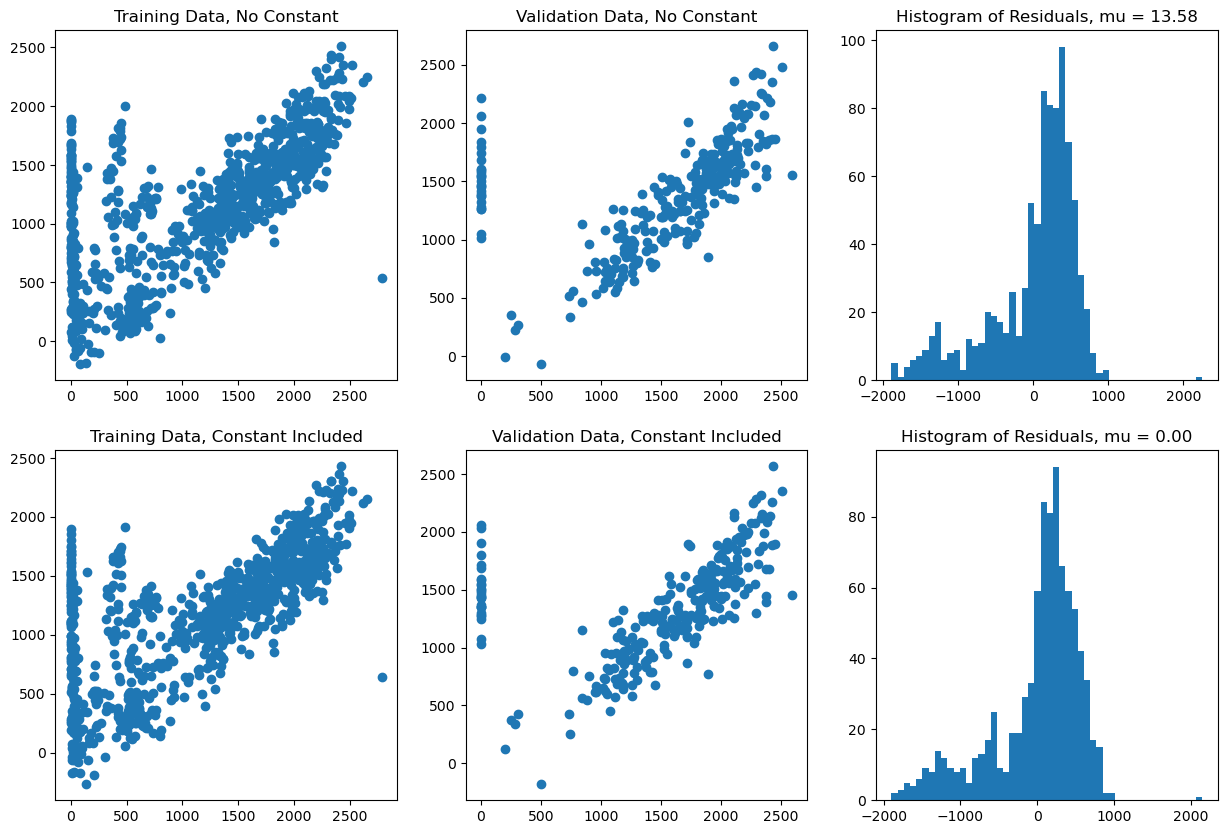

In [9]:
model = sm.OLS(Y_train_filtered, X_train_filtered)
model_fitted = model.fit()
pred_train = model_fitted.predict(X_train_filtered)
pred_val = model_fitted.predict(X_val_filtered)
print(model_fitted.summary())

X_train_filtered_with_constant = sm.add_constant(X_train_filtered)
X_val_filtered_with_constant = sm.add_constant(X_val_filtered)
model = sm.OLS(Y_train_filtered, X_train_filtered_with_constant)
model_fitted_with_constant = model.fit()
pred_train_with_constant = model_fitted_with_constant.predict(X_train_filtered_with_constant)
pred_val_with_constant = model_fitted_with_constant.predict(X_val_filtered_with_constant)
print(model_fitted_with_constant.summary())

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(2, 3, 1)
ax.scatter(Y_train_filtered, pred_train)
ax.set_title('Training Data, No Constant')
ax = fig.add_subplot(2, 3, 2)
ax.scatter(Y_val_filtered, pred_val)
ax.set_title('Validation Data, No Constant')
ax = fig.add_subplot(2, 3, 3)
ax.hist(model_fitted.resid, 50)
ax.set_title('Histogram of Residuals, mu = %1.2f' % np.mean(model_fitted.resid))

ax = fig.add_subplot(2, 3, 4)
ax.scatter(Y_train_filtered, pred_train_with_constant)
ax.set_title('Training Data, Constant Included')
ax = fig.add_subplot(2, 3, 5)
ax.scatter(Y_val_filtered, pred_val_with_constant)
ax.set_title('Validation Data, Constant Included')
ax = fig.add_subplot(2, 3, 6)
ax.hist(model_fitted_with_constant.resid, 50)
ax.set_title('Histogram of Residuals, mu = %1.2f' % np.mean(model_fitted_with_constant.resid))

Looking at the above, you can see why this is not always an easy error to notice:
* Our scatter plots look really similar, not much difference between the model with and without a constant term
* Our model without the constant term has a much better $R^2$

The only hint that something is wrong is the histogram of the residuals. 

This result probably seems a bit contradictory - why include a constant if our model is better off without one? Not really. If we don't include the constant we end up in trouble with our residuals. Our residuals should follow a normal distribution, centred around 0 (i.e. the mean of the residuals should be 0). Without the constant term, this clearly is not the case.

One other common error you may cause when adding not/adding a constant is having a constant for your training set and not your validation set, and vice versa. This will result in errors.

In [10]:
model_fitted_with_constant.predict(X_train_filtered)

ValueError: shapes (888,7) and (8,) not aligned: 7 (dim 1) != 8 (dim 0)

In [11]:
model_fitted.predict(X_train_filtered_with_constant)

ValueError: shapes (888,8) and (7,) not aligned: 8 (dim 1) != 7 (dim 0)

Here we simply get shape errors, because we are giving our model too many (or too few) predictors.

## Not Standardising Correctly

So, having read the above you've decided that constant terms aren't for you and you'd rather just standardise your data and be done with it. Fair enough, but make sure you standardise correctly.

The below looks pretty correct, but isn't.

123.56919240669241
184.17246519331772


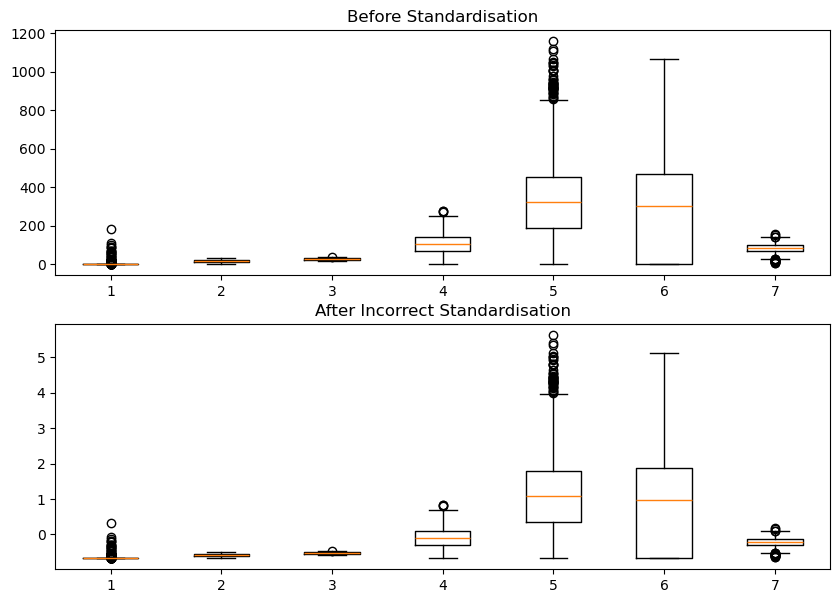

In [12]:
mu_train = np.mean(X_train_filtered)
sigma_train = np.std(X_train_filtered)

X_train_std = (X_train_filtered - mu_train)/sigma_train

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(2, 1, 1)
ax.boxplot(X_train_filtered)
ax.set_title('Before Standardisation')
ax = fig.add_subplot(2, 1, 2)
ax.boxplot(X_train_std)
ax.set_title('After Incorrect Standardisation')

print(mu_train)
print(sigma_train)

This is another one where there's no actual red text. What's happened is that when we've computed the mean and standard deviation, we've done this over the whole dataset, i.e. we've got the mean and standard deviation of everything, rather than just of the individual dimensions, so we've applied a uniform shift and scale to the whole dataset. 

Looking at the box plots, we see that shape of these two plots and relative scale between dimensions is unchanged, though the y-axis scale has changed due to the scaling operation we performed.

What we want to do is what we've got below.

[  2.83423423  18.14481982  26.57398649 106.6722973  336.83220721
 290.67792793  83.24887387]
[ 11.76576953   6.52913914   3.91521764  49.27073623 245.27055295
 252.38618853  23.21797414]


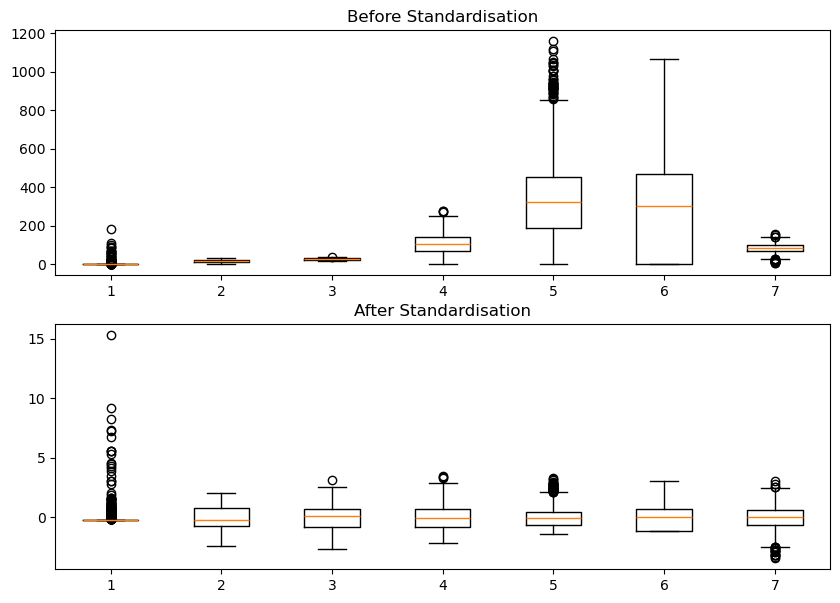

In [13]:
mu_train = np.mean(X_train_filtered, axis=0)
sigma_train = np.std(X_train_filtered, axis=0)

X_train_std = (X_train_filtered - mu_train)/sigma_train

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(2, 1, 1)
ax.boxplot(X_train_filtered)
ax.set_title('Before Standardisation')
ax = fig.add_subplot(2, 1, 2)
ax.boxplot(X_train_std)
ax.set_title('After Standardisation')

print(mu_train)
print(sigma_train)

Here, our `mean` and `std` calls operate over `axis=0`, such that we get a mean and standard deviation for each column. The box plot then shows that we've got this right as all of our data series are centred around 0.

If you're not confident computing the mean and standard deviation yourself, you can use the `StandardScaler` object like we do below, but try to avoid the error we demonstrate there.

## Not Standardising Consistently

This is an error that a bunch of people make every year - don't be one of them, remember: **you should only compute the mean and standard deviation on the training set**.

Text(0.5, 1.0, 'Incorrect Standardisation, RMSE: 0.886')

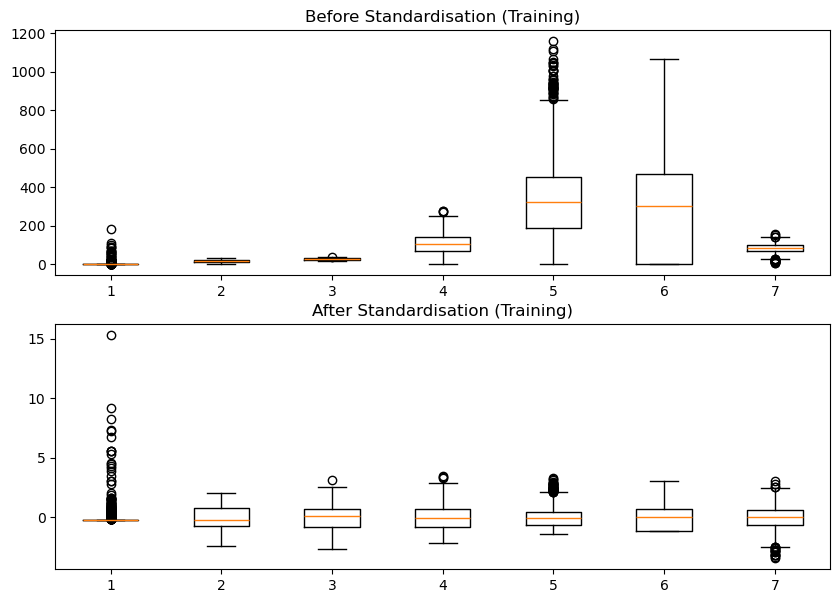

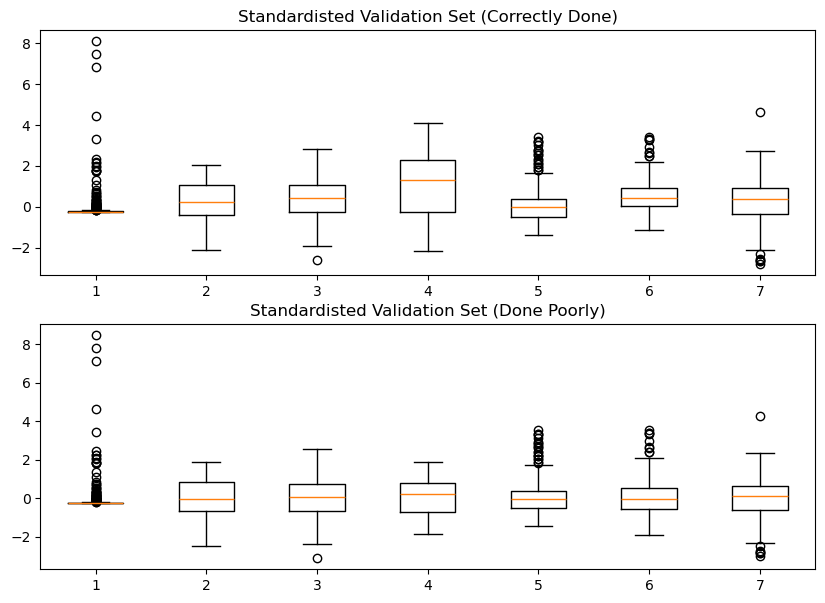

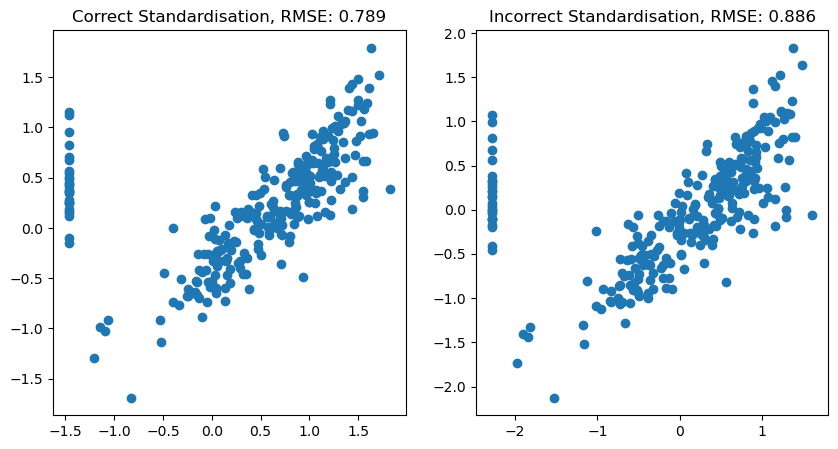

In [14]:
x_train_scaler = StandardScaler().fit(X_train_filtered)
y_train_scaler = StandardScaler().fit(Y_train_filtered.reshape(-1, 1))

X_train_std = x_train_scaler.transform(X_train_filtered)
Y_train_std = y_train_scaler.transform(Y_train_filtered.reshape(-1, 1))
X_val_std_correct = x_train_scaler.transform(X_val_filtered)
Y_val_std_correct = y_train_scaler.transform(Y_val_filtered.reshape(-1, 1))

# Wrong, wrong, wrong, wrong, wrong!!!
# We've already computed the mean and std.dev above for the training set, we shouldn't do it again
x_val_scaler = StandardScaler().fit(X_val_filtered)
y_val_scaler = StandardScaler().fit(Y_val_filtered.reshape(-1, 1))
X_val_std_wrong = x_val_scaler.transform(X_val_filtered)
Y_val_std_wrong = y_val_scaler.transform(Y_val_filtered.reshape(-1, 1))

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(2, 1, 1)
ax.boxplot(X_train_filtered)
ax.set_title('Before Standardisation (Training)')
ax = fig.add_subplot(2, 1, 2)
ax.boxplot(X_train_std)
ax.set_title('After Standardisation (Training)')

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(2, 1, 1)
ax.boxplot(X_val_std_correct)
ax.set_title('Standardisted Validation Set (Correctly Done)')
ax = fig.add_subplot(2, 1, 2)
ax.boxplot(X_val_std_wrong)
ax.set_title('Standardisted Validation Set (Done Poorly)')

model = sm.OLS(Y_train_std, X_train_std)
model_fit = model.fit()
preds_correct = model_fit.predict(X_val_std_correct)
preds_wrong = model_fit.predict(X_val_std_wrong)

fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(Y_val_std_correct, preds_correct)
rmse = np.sqrt(np.mean(np.power(Y_val_std_correct.reshape(-1) - preds_correct, 2.0)))
ax.set_title('Correct Standardisation, RMSE: %1.3f' % rmse)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(Y_val_std_wrong, preds_wrong)
rmse = np.sqrt(np.mean(np.power(Y_val_std_wrong.reshape(-1) - preds_wrong, 2.0)))
ax.set_title('Incorrect Standardisation, RMSE: %1.3f' % rmse)

This is another one that's not obvious at first glance. 

The top box plots are there to show that our standardisation has worked on the training set - I'm showing again as a reminder after the error that was looked at before this (standardising incorrectly/ineffectivley).

The second set of box plots show our validation data. Of this pair, the top plot is with things done right. Here we see that our box plot actually shows our data looking a bit off. The data is not all centred about 0, some dimensions seem to be shifted slightly. While this is not ideal, it's a result of the distributions of our two sets (train and validation) not being identical.

Looking at the preditions finally, we do see an increase in the error with the incorrect standardisation, but you won't always see this (it will depend on the data).

This is an error that often won't be obvious, so the best prevention is to keep repeating to youself **I must only compute the mean and standard deviation for standardisation on the training set**. 

## Dimension Mismatch when Evaluating

This is a fun one. This is another one that won't give any red text, but will screw with your mind. 

In [15]:
# train a model
model = sm.OLS(Y_train_std, X_train_std)
model_fit = model.fit()
# make some predictions
preds = model_fit.predict(X_val_std_correct)

# get some shapes
print(preds.shape)
print(Y_val_std_correct.shape)

# compute an RMSE - but it won't go well
error = preds - Y_val_std_correct
print(error.shape)
sq_error = np.power(error, 2.0)
print(sq_error.shape)
mse = np.mean(sq_error)
print(mse.shape)
rmse = np.sqrt(mse)
print(rmse.shape)
print(rmse)

(276,)
(276, 1)
(276, 276)
(276, 276)
()
()
1.0394637183372906


So, what happened?

We had some predictions, and some ground truth values. Both were in vectors, one of size `(276,)` and one of size `(276,1)`. Surely we can just subtract one from the other to get an error?

No. If we do this, we get a square matrix back of size `(276, 276)`. Essentially, we subtract the first value in ground truth from all values in predcitions. That gives us one column. Then we do that again, and again, and so on. We can then continue to compute our RMSE and it all seems to go well - but our final measure is the not the RMSE, it's some weird thing that we don't want.

The solution is to run our ground truth, which is the variable that `(276,1)` through `reshape(-1)` to also get it into shape `(276,)`. Then, our errors are of shape `(276,)` and all proceeds correctly. Note that you won't always need to do this. Usually, this issue appears after using the standard scaler as that will lead to this `(N, 1)` shape rather than `(N, )`, where $N$ is the number of samples.

One place this error can manifest and hide is when doing regularised regression. Computing the RMSE incorrectly due to this error will lead to you selecting a wildly incorrect value for $\lambda$, and possibly even choosing $\lambda=0$ when you should be selecting something else.

In [16]:
# now computer an RMSE properly
error = preds - Y_val_std_correct.reshape(-1)
print(error.shape)
sq_error = np.power(error, 2.0)
print(sq_error.shape)
mse = np.mean(sq_error)
print(mse.shape)
rmse = np.sqrt(mse)
print(rmse.shape)
print(rmse)

(276,)
(276,)
()
()
0.7893211563498616


## Needless Constant Term

Before we left one out when we should have had one. Let's now include one that we don't need.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.474
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                              113.2
Date:                Tue, 06 Feb 2024   Prob (F-statistic):                   3.34e-118
Time:                        05:50:57   Log-Likelihood:                         -975.11
No. Observations:                 888   AIC:                                      1964.
Df Residuals:                     881   BIC:                                      1998.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0.5, 1.0, 'Histogram of Residuals, mu = -0.00')

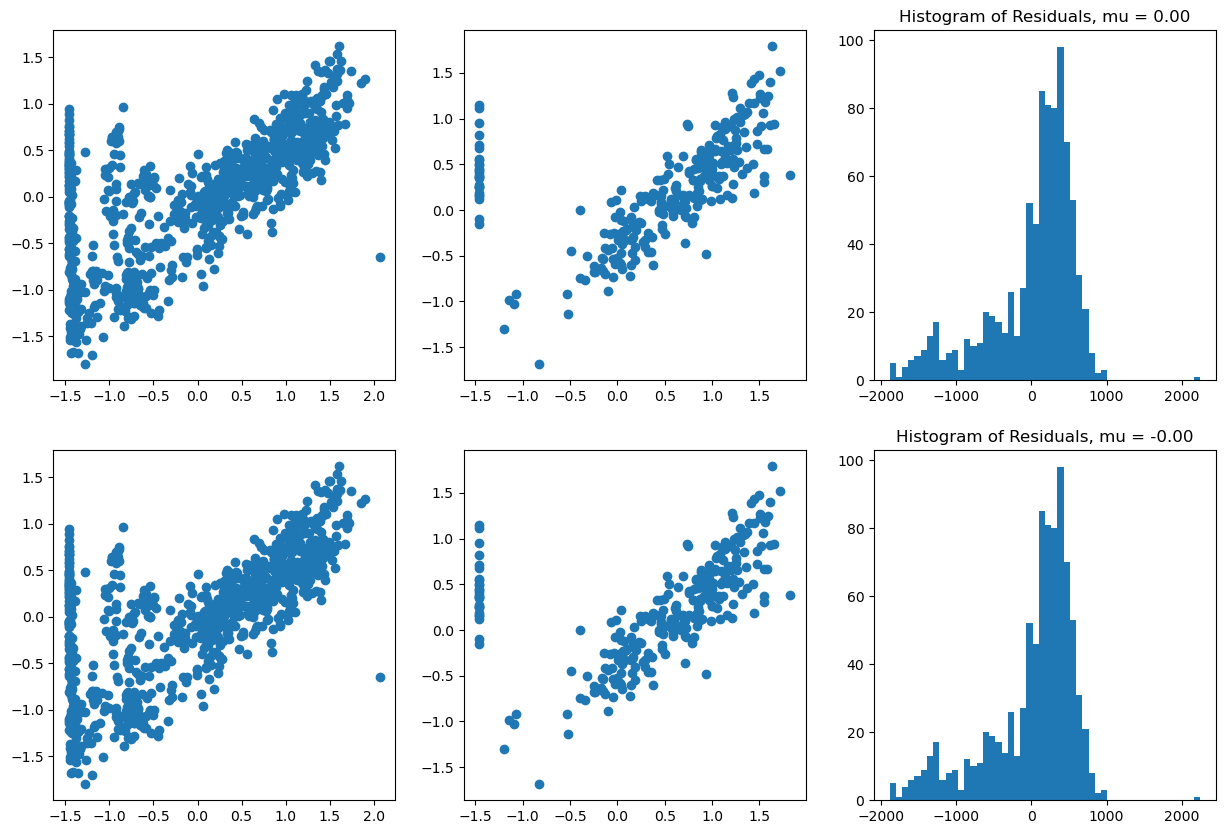

In [17]:
model = sm.OLS(Y_train_std, X_train_std)
model_fit = model.fit()
pred_train = model_fit.predict(X_train_std)
pred_val = model_fit.predict(X_val_std_correct)
print(model_fit.summary())

X_train_std_with_constant = sm.add_constant(X_train_std)
X_val_std_with_constant = sm.add_constant(X_val_std_correct)
model = sm.OLS(Y_train_std, X_train_std_with_constant)
model_fit_with_constant = model.fit()
pred_train_with_constant = model_fit_with_constant.predict(X_train_std_with_constant)
pred_val_with_constant = model_fit_with_constant.predict(X_val_std_with_constant)
print(model_fit_with_constant.summary())

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(2, 3, 1)
ax.scatter(Y_train_std, pred_train)
ax = fig.add_subplot(2, 3, 2)
ax.scatter(Y_val_std_correct, pred_val)
ax = fig.add_subplot(2, 3, 3)
ax.hist(model_fitted.resid, 50)
ax.set_title('Histogram of Residuals, mu = %1.2f' % np.mean(model_fit.resid))

ax = fig.add_subplot(2, 3, 4)
ax.scatter(Y_train_std, pred_train_with_constant)
ax = fig.add_subplot(2, 3, 5)
ax.scatter(Y_val_std_correct, pred_val_with_constant)
ax = fig.add_subplot(2, 3, 6)
ax.hist(model_fitted.resid, 50)
ax.set_title('Histogram of Residuals, mu = %1.2f' % np.mean(model_fit_with_constant.resid))

Here, we see that the models are pratically identical. The only difference is that one model has the constant term, and it's got a really rubbish p-value because it's really not needed.

Adding this doesn't cause any problems for our residuals, but it just adds a junk term to our model that we don't need. In some cases, most likley those with very noisy and/or limited data, it may cause more of a problem. 

This is another error that doesn't jump off the page at us, but the practically 0 value for the intercept, combined with the poor p-value for it, gives us quite a strong hint that this term should not be here.